In [1]:
import simpy
import pandas as pd
from datetime import timedelta
from datetime import datetime
import numpy as np
import csv
import matplotlib.pyplot as plt 

In [2]:
#Read a list of Names and Appointment Datetimes from a file (representing the appointment book)
with open('/home/mrsmin/py_primarycare_sim/patient_list1.txt') as f:
    r = csv.reader(f, delimiter='\t')
    pt_lst = list(tuple(line) for line in r)

#Remove the column headers
pt_lst = pt_lst[1:]
#display to confirm this worked
pt_lst[0:5]

[('Emma Johnson', '2023-02-05 08:00'),
 ('Olivia Brown', '2023-02-05 08:10'),
 ('Ava Smith', '2023-02-05 08:20'),
 ('Noah Taylor', '2023-02-05 08:30'),
 ('Ethan Thompson', '2023-02-05 08:40')]

In [3]:
#Create a Doctor class. 
# This program assumes just one doctor but we could have a more realistic appointment book 
# showing which one of several doctors that patient will see
class Doctor:
    def __init__(self, doc_name):
        self.doc_name = doc_name
        self.status = "Available"
        self.status_change_time = [("Available",'2023-02-05 08:00' )]


doc1 = Doctor("Mumpzenmezle")

doc1.doc_name

'Mumpzenmezle'

In [19]:
class Patient:
    def __init__(self, Name, AppointmentDateTime):
        self.Name = Name
        self.AppointmentDateTime = datetime.strptime(AppointmentDateTime, '%Y-%m-%d %H:%M')
        self.status = "Not arrived"
        self.start_consult = None
        #Patient randomly arrives 15 mins either side of appt, with a median of 5 mins early, from triangle distribution.
        self.arrival_time = self.AppointmentDateTime + timedelta(seconds=np.random.triangular(-900, -300, 900 ))
        self.arrival_time = self.arrival_time.replace(microsecond=0)

        if self.AppointmentDateTime == self.arrival_time:
            self.arrival_class = "On Time"
        elif self.arrival_time > self.AppointmentDateTime:
            self.arrival_class = f"{self.arrival_time - self.AppointmentDateTime} Late"
        else:
            self.arrival_class = f"{self.AppointmentDateTime - self.arrival_time} Early"

    def arrives(self, myclock):
        if myclock == self.arrival_time:
            self.status = "Arrived"
            print(f"{self.Name} {self.status} {self.arrival_class}, {myclock.strftime('%m/%d/%Y, %H:%M:%S')}")
            

    def consultation(self, myclock):
        if myclock >= self.AppointmentDateTime and self.status == "Arrived" and doc1.status=="Available":
            self.start_consult = myclock
            self.status = "Being Seen"
            doc1.status = "Busy"
            doc1.status_change_time.append((doc1.status, myclock))
            self.wait_time = self.start_consult - max(self.AppointmentDateTime, self.arrival_time)
            print(f"{self.Name} is {self.status}, waited {self.wait_time} , {doc1.doc_name} is {doc1.status} {myclock.strftime('%m/%d/%Y, %H:%M:%S')}")


    def consultation_ends(self, myclock):
        if self.status == "Being Seen":
            #random consultation duration from triangular distribution.
            # min 5 minutes, median 8 mins, max 20 mins
            if myclock >= self.start_consult + timedelta(seconds=np.random.triangular(300, 480, 1200)): 
                self.consult_duration = myclock - self.start_consult
                self.status = "Finished Consult"
                doc1.status = "Available"
                doc1.status_change_time.append((doc1.status, myclock))
                print(f"{self.Name} {self.status}, Duration {self.consult_duration}, {doc1.doc_name} is {doc1.status}, {myclock.strftime('%m/%d/%Y, %H:%M:%S')}")



In [20]:
#list comprehension creates a patient for every row in list
AppointmentBook = [Patient(*x) for x in pt_lst]

In [22]:
alln = [patient.arrival_time for patient in AppointmentBook]

alln[0:5]

[datetime.datetime(2023, 2, 5, 7, 57, 25),
 datetime.datetime(2023, 2, 5, 8, 2, 44),
 datetime.datetime(2023, 2, 5, 8, 16, 45),
 datetime.datetime(2023, 2, 5, 8, 28, 50),
 datetime.datetime(2023, 2, 5, 8, 35, 48)]

In [23]:
# We will step though time by incrementing myclock in one second steps, starting at the point shown here
myclock = datetime.strptime("2023-02-05 07:45", '%Y-%m-%d %H:%M')


In [24]:
doc1.status = "Available"

for i in range(100000):
    myclock = myclock + timedelta(seconds = 1)
    for patient in AppointmentBook:
        patient.arrives(myclock)
        patient.consultation(myclock)
        patient.consultation_ends(myclock)


Emma Johnson Arrived 0:02:35 Early, 02/05/2023, 07:57:25
Emma Johnson is Being Seen, waited 0:00:00 , Mumpzenmezle is Busy 02/05/2023, 08:00:00
Olivia Brown Arrived 0:07:16 Early, 02/05/2023, 08:02:44
Emma Johnson Finished Consult, Duration 0:06:47, Mumpzenmezle is Available, 02/05/2023, 08:06:47
Olivia Brown is Being Seen, waited 0:00:00 , Mumpzenmezle is Busy 02/05/2023, 08:10:00
Olivia Brown Finished Consult, Duration 0:06:24, Mumpzenmezle is Available, 02/05/2023, 08:16:24
Ava Smith Arrived 0:03:15 Early, 02/05/2023, 08:16:45
Ava Smith is Being Seen, waited 0:00:00 , Mumpzenmezle is Busy 02/05/2023, 08:20:00
Ava Smith Finished Consult, Duration 0:05:58, Mumpzenmezle is Available, 02/05/2023, 08:25:58
Noah Taylor Arrived 0:01:10 Early, 02/05/2023, 08:28:50
Noah Taylor is Being Seen, waited 0:00:00 , Mumpzenmezle is Busy 02/05/2023, 08:30:00
Noah Taylor Finished Consult, Duration 0:05:42, Mumpzenmezle is Available, 02/05/2023, 08:35:42
Ethan Thompson Arrived 0:04:12 Early, 02/05/2023

In [25]:
appts = [patient.AppointmentDateTime for patient in AppointmentBook]

waits = [timedelta.total_seconds(patient.wait_time) for patient in AppointmentBook]

durations = [timedelta.total_seconds(patient.consult_duration) for patient in AppointmentBook]

<function matplotlib.pyplot.show(close=None, block=None)>

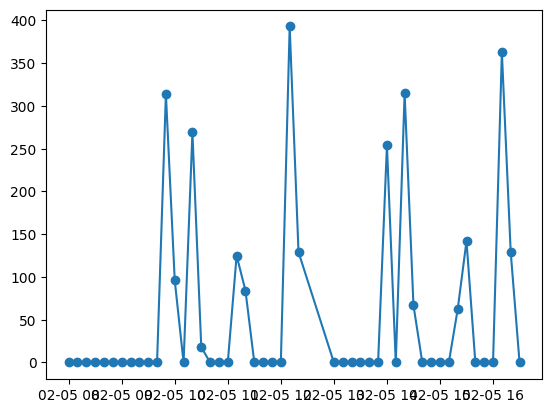

In [26]:
plt.plot(appts, waits, marker = 'o', linestyle = '-')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

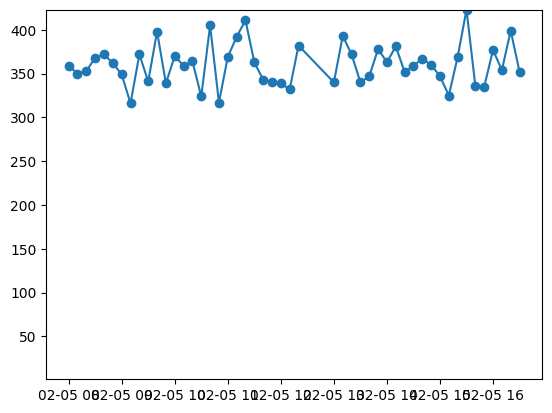

In [11]:
plt.plot(appts, durations, marker = 'o', linestyle = '-')

plt.ylim(bottom=1, top = max(durations))

plt.show

In [22]:
doc_status_change = pd.DataFrame(doc1.status_change_time, columns=['Status','DateTime'])

doc_status_change['DateTime'] = pd.to_datetime(doc_status_change['DateTime'])

doc_status_change['TimeDiff'] = doc_status_change['DateTime'].diff()

doc_status_change['Status'] = doc_status_change['Status'].shift(1)

doc_status_change

,Status,DateTime,TimeDiff
0,None,2023-02-05 08:00:00,NaT
1,Available,2023-02-05 08:00:00,0 days 00:00:00
2,Busy,2023-02-05 08:06:49,0 days 00:06:49
3,Available,2023-02-05 08:10:00,0 days 00:03:11
4,Busy,2023-02-05 08:16:48,0 days 00:06:48
...,...,...,...
94,Busy,2023-02-05 16:17:04,0 days 00:06:45
95,Available,2023-02-05 16:20:00,0 days 00:02:56
96,Busy,2023-02-05 16:26:29,0 days 00:06:29
97,Available,2023-02-05 16:30:00,0 days 00:03:31


In [31]:
durations

[340.0,
 370.0,
 359.0,
 358.0,
 363.0,
 395.0,
 362.0,
 368.0,
 382.0,
 411.0,
 426.0,
 397.0,
 351.0,
 374.0,
 366.0,
 347.0,
 401.0,
 353.0,
 314.0,
 392.0,
 378.0,
 356.0,
 366.0,
 357.0,
 381.0,
 392.0,
 373.0,
 389.0,
 368.0,
 370.0,
 408.0,
 328.0,
 359.0,
 404.0,
 358.0,
 346.0,
 381.0,
 375.0,
 381.0,
 376.0,
 352.0,
 369.0,
 357.0,
 397.0,
 413.0,
 389.0,
 371.0,
 397.0,
 341.0]